In [1]:
import os 
import cv2 
import time
import json 
import glob 
import torch 
import numpy as np
from typing import Tuple,Union
import matplotlib.pyplot as plt 

## Agenda 
- Face detection with MTCNN using Facenet-Pytorch package 
- Computing face embeddings using the Facenet-Pytorch package 
- Working with yolov5 in OpenCV for object detection
- Integrating the above in the streamlit UI with mediapipe 

In [4]:
ASSETS_DIR = "assets"
# Create the network from the ONNX yolov5 model file
net = cv2.dnn.readNet(os.path.join(ASSETS_DIR,"yolov5s.onnx"))
print(net)

<dnn_Net 00000141D3070FD0>


In [219]:
img = cv2.imread(os.path.join(ASSETS_DIR,"person-phone-2.jpg"))

# resize to 640x640
resized_img = cv2.resize(img, (640,640), cv2.INTER_AREA)
cv2.imshow('image',resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [232]:
def detect_yolov5(image:np.ndarray)->np.ndarray:
    """Compute detection predictions 

    Args: 
        image (np.ndarray): input image 
    
    Returns: 
        predictions (np.ndarray): computed detections 
    """
    resized_img = cv2.resize(image, (640,640), cv2.INTER_AREA)
    # normalize the image, swap Red and Blue channels, and generate the image blob 
    blob = cv2.dnn.blobFromImage(resized_img, 1/255.0, (640,640), swapRB=True,crop=False)
    # perform a forward pass to obtain the output predictions
    net.setInput(blob)
    start = time.time()
    predictions = net.forward()
    end = time.time()
    print(f"Total time elapsed for prediction: {(end-start):>.2f}s")
    output = predictions[0]
    return output

In [220]:
# normalize the image, swap Red and Blue channels, and generate the image blob 
blob = cv2.dnn.blobFromImage(resized_img, 1/255.0, (640,640), swapRB=True,crop=False)
# set the blob as the input to the network
net.setInput(blob)
# perform a forward pass to obtain the output predictions
start = time.time()
predictions = net.forward()
end = time.time()
print(f"Total time elapsed for prediction: {(end-start):>.2f}s")
print(predictions)
print(predictions.shape)
output = predictions[0]

Total time elapsed for prediction: 0.81s
[[[4.1539564e+00 3.9948077e+00 8.0281181e+00 ... 2.3850119e-03
   5.3338951e-04 1.8355289e-03]
  [1.1398924e+01 4.3968639e+00 2.3457497e+01 ... 2.4870099e-03
   6.8303256e-04 1.3683210e-03]
  [1.6691528e+01 3.7411666e+00 3.2021282e+01 ... 2.5160585e-03
   7.8075612e-04 1.6942072e-03]
  ...
  [5.5855420e+02 6.0897168e+02 1.6865466e+02 ... 3.0899681e-03
   8.7435858e-04 1.1351294e-03]
  [5.9256439e+02 6.1073810e+02 1.0612916e+02 ... 3.7000845e-03
   1.0646558e-03 1.2303196e-03]
  [6.2092389e+02 6.1586945e+02 1.0470250e+02 ... 2.7910394e-03
   1.1361782e-03 1.3992164e-03]]]
(1, 25200, 85)


In [236]:
def process_detections(input_image:np.ndarray,output_predictions:np.ndarray, threshold:float=0.45)->Tuple[list,list,list]:
    """Process the output predictions from the network 

    Args: 
        input_image (np.ndarray): The original input image
        output_predictions (np.ndarray): Output predictions from the network
        threshold (float): Confidence threshold for the predictions

    Returns:
        class_idxs (list): List of class IDs for the predicted classes
        confidences (list): List of confidences for the predicted classes
        bboxes (list): List of bounding boxes for the predicted classes
    """
    class_idxs = []
    confidences = []
    bboxes = []

    orig_h, orig_w = input_image.shape[:2]
    x_ratio = orig_w/640 
    y_ratio = orig_h/640

    for i in range(output_predictions.shape[0]):
        row = output_predictions[i]
        confidence = row[4]
        # filter detections with confidence less than the specified threshold
        if confidence >= threshold:
            classes_scores = row[5:]
            # compute the class ID with the max score for each detection
            _,_,_,max_idx = cv2.minMaxLoc(classes_scores)
            class_id = max_idx[1]
            if(classes_scores[class_id] > .25):
                confidences.append(confidence)
                class_idxs.append(class_id)
                x,y,w,h = row[0].item(), row[1].item(), row[2].item(), row[3].item()
                # re-scale the xywh coordinates to the actual input dimensions
                left = int((x - 0.5 * w) * x_ratio)
                top = int((y - 0.5 * h) * y_ratio)
                width = int(w * x_ratio)
                height = int(h * y_ratio)
                box = np.array([left, top, width, height])
                bboxes.append(box)

    return class_idxs, confidences, bboxes

In [222]:
class_idxs, confidences, bboxes = process_detections(img, output)

In [243]:
# NMS - To filter out overlapping detections 
def apply_nms(
    class_idxs:Union[list,np.ndarray],
    bboxes:Union[list,np.ndarray],
    confidences:Union[list,np.ndarray],
    conf_threshold:float=0.4,
    nms_threshold:float=0.4
)->Tuple[list,list,list]:
    """Apply Non-maximum suppression to filter out overlapping detections 

    Args: 
        class_idxs (list): The predicted class IDs from Yolo 
        bboxes (list): The predicted bounding boxes from Yolo 
        confidences (list): The predicted confidences from Yolo 
        conf_threshold (float): The confidence threshold for the NMS, default = 0.5
        nms_threshold (float): 

    Returns: 
        result_class_idxs (list): Resulting class IDs after applying NMS
        result_confidences (list): Resulting confidences after applying NMS
        result_bboxes (list): Resulting bounding boxes after applying NMS
    """
    nms_idxs = cv2.dnn.NMSBoxes(bboxes, confidences, conf_threshold, nms_threshold)
    result_class_idxs = []
    result_confidences = []
    result_bboxes = []

    for i in nms_idxs:
        result_class_idxs.append(class_idxs[i])
        result_confidences.append(confidences[i])
        result_bboxes.append(bboxes[i])

    return (
        result_class_idxs,
        result_confidences,
        result_bboxes
    )

In [224]:
with open(os.path.join(ASSETS_DIR,"classes.txt"),"r") as f:
    classes = [c.strip() for c in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes),3))

with open('coco_colors.npy','wb') as f:
    np.save(f, COLORS)

In [225]:
COLORS = np.load(open('coco_colors.npy','rb'))

In [245]:
# drawing the bouuding boxes on the image 
# TODO: Draw bounding boxes for a pre-defined set of classes
def draw_bounding_boxes(image:np.ndarray,class_idxs:Union[list,np.ndarray],bboxes:Union[list,np.ndarray],confidences:Union[list,np.ndarray],show:bool=True):
    for i in range(len(class_idxs)):
        bbox = bboxes[i]
        class_id = class_idxs[i]
        color = COLORS[class_id]
        conf  = confidences[i]
        cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[0]+bbox[2],bbox[1]+bbox[3]), color, 2)
        cv2.rectangle(image, (bbox[0], bbox[1] - 20), (bbox[0] + bbox[2], bbox[1]), color, -1)
        label = f"{classes[class_id]} {round(conf*100,2)}%"
        cv2.putText(image, label, (bbox[0] + 5, bbox[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))

    if show: 
        cv2.imshow('frame',image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [250]:
test_img = cv2.imread(os.path.join(ASSETS_DIR,"person-phone-2.jpg"))
output_predictions = detect_yolov5(test_img)
class_idxs, confidences, bboxes = process_detections(test_img, output_predictions)
result = apply_nms(class_idxs,bboxes,confidences)
# print(result)
image = test_img.copy()
draw_bounding_boxes(image, result[0], result[2], result[1])

Total time elapsed for prediction: 1.02s


Facenet Pytorch exploration

In [5]:
import random
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, InceptionResnetV1

In [6]:
# Create face detector
mtcnn = MTCNN(select_largest=False,keep_all=True)
face_image_path = random.choice(glob.glob(f"{ASSETS_DIR}/face_images/**/*.jpg"))
face_image = Image.open("assets/football-2.jpg")

# Detect face
boxes, prob, points = mtcnn.detect(face_image,landmarks=True)


(-0.5, 719.5, 397.5, -0.5)

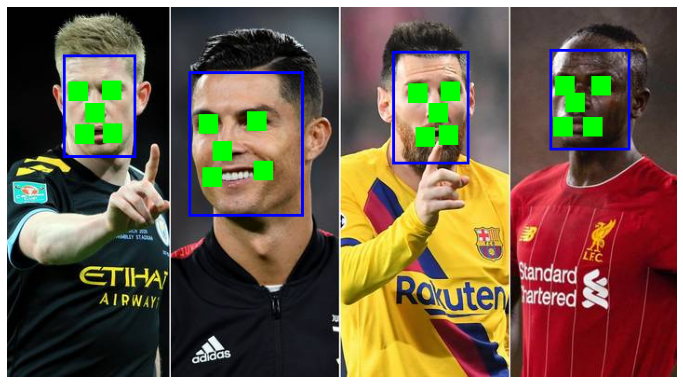

In [7]:
plt.figure(figsize=(12,8))
img = face_image.copy()
draw = ImageDraw.Draw(img)
for (box,point) in zip(boxes,points):
    draw.rectangle(box,outline=(0,0,255),width=3)
    for p in point: 
        coords = (p+10).tolist()+(p-10).tolist()
        draw.rectangle(coords,fill=(0,255,0), width=1)
plt.imshow(img)
plt.axis('off')

In [79]:
mtcnn = MTCNN(image_size=160, margin=20)
# For a model pretrained on VGGFace2
resnet_model = InceptionResnetV1(pretrained='vggface2').eval()

In [103]:
def encode_image(image_path:str,model)->torch.Tensor:
    """Compute the face embedding using MTCNN and a pre-trained model from facenet_pytorch

    Args: 
        image_path (str): Path to the image 
        model: pre-trained model from facenet_pytorch package
    """
    img = Image.open(image_path)
    # Crop the image using MTCNN
    img_cropped = mtcnn(img,save_path=None)
    embedding = model(img_cropped.unsqueeze(0))
    return embedding

In [106]:
face_image_path = random.choice(glob.glob(f"{ASSETS_DIR}/face_images/**/*.jpg"))
print(face_image_path)
encode_image(face_image_path,resnet_model)

assets/face_images\frank_lampard\10.jpg
torch.Size([3, 160, 160])


tensor([[ 2.7997e-02, -1.1086e-02,  8.6563e-03,  6.7121e-03, -3.0694e-02,
          6.6210e-02,  7.7396e-02,  3.7882e-02,  1.2443e-04,  7.0242e-04,
         -8.8733e-02,  2.5156e-02, -7.0325e-02,  6.5803e-02,  8.9702e-03,
         -1.3072e-02,  3.2632e-02, -5.6083e-02,  2.2264e-02, -3.1607e-02,
          1.3476e-02,  1.5591e-03,  2.4097e-02,  3.4805e-02,  7.4667e-02,
         -1.7804e-02,  3.9559e-02,  4.4647e-02,  2.6604e-02, -6.6021e-02,
          4.6308e-04,  1.7194e-02, -1.9872e-02,  8.1618e-04, -6.9030e-02,
          1.9766e-02,  5.3688e-05,  6.6263e-02,  2.2999e-02, -8.0517e-02,
          7.8318e-02, -3.8479e-02, -4.8228e-02,  3.0075e-02,  7.7375e-02,
         -5.7314e-02,  3.8831e-02, -4.4181e-02,  3.2077e-02,  1.8673e-02,
          8.1105e-02, -2.5151e-02, -1.4508e-02, -2.2404e-02, -2.2160e-02,
          6.8349e-02, -9.3628e-02,  4.0365e-02,  5.5296e-02, -6.4371e-02,
         -3.8732e-02, -3.3002e-02, -1.0775e-02,  1.1471e-02, -2.3299e-03,
          3.5811e-02,  1.6444e-02,  5.

In [98]:
# create a database of face embeddings
face_encoding_database = {}
FACE_IMAGES_DIR = f"{ASSETS_DIR}/face_images"
for person in os.listdir(FACE_IMAGES_DIR):
    face_image_path = random.choice(glob.glob(f"{FACE_IMAGES_DIR}/{person}/*.jpg"))
    print(face_image_path)
    if person not in face_encoding_database:
        face_encoding_database[person] = encode_image(face_image_path,resnet_model)

assets/face_images/angelina_jolie\10.jpg
assets/face_images/anthony_joshua\1.jpg
assets/face_images/beyonce\10.jpg
assets/face_images/chadwick_boseman\10.jpg
assets/face_images/cristiano_ronaldo\10.jpg
assets/face_images/donald_trump\1.jpg
assets/face_images/elon_musk\1.jpg
assets/face_images/frank_lampard\1.jpg
assets/face_images/jayz\1.jpg
assets/face_images/kanye_west\1.jpg
assets/face_images/michelle_obama\1.jpg


In [83]:
print(face_encoding_database.keys())

dict_keys(['angelina_jolie', 'anthony_joshua', 'beyonce', 'chadwick_boseman', 'cristiano_ronaldo', 'donald_trump', 'elon_musk', 'frank_lampard', 'jayz', 'kanye_west', 'michelle_obama'])


In [84]:
def compute_distance(encoding_1:torch.Tensor,encoding_2:torch.Tensor):
    diff = encoding_1 - encoding_2
    return diff.norm(dim=1).item()

In [94]:
encodings = list(face_encoding_database.values())

compute_distance(encodings[0],encodings[10])

1.1995750665664673

In [44]:
face_encoding_database.keys()

dict_keys(['angelina_jolie', 'anthony_joshua', 'beyonce', 'chadwick_boseman', 'cristiano_ronaldo', 'donald_trump', 'elon_musk', 'frank_lampard', 'jayz', 'kanye_west', 'michelle_obama', 'naomi_campbell'])